# Getting started with xgcm for MOM6

- MOM6 variables are staggered according to the Arakawa C-grid
- It uses a north-east index convention
- center points are labelled (xh, yh) and corner points are labelled (xq, yq)
- important: variables xh/yh, xq/yq that are named “nominal” longitude/latitude are not the true geographical coordinates and are not suitable for plotting (more later)

In [1]:
import xarray as xr
from xgcm import Grid
import warnings
import matplotlib.pylab as plt
from cartopy import crs as ccrs
import numpy as np
import pydap

In [2]:
dataurl = 'http://35.188.34.63:8080/thredds/dodsC/OM4p5/'

ds = xr.open_dataset(f'{dataurl}/ocean_monthly_z.200301-200712.nc4',
                     chunks={'time':1, 'z_l': 1}, drop_variables=['average_DT',
                                                                  'average_T1',
                                                                  'average_T2'],
                     engine='pydap')

In [3]:
ds

<xarray.Dataset>
Dimensions:       (nv: 2, time: 60, xh: 720, xq: 720, yh: 576, yq: 576, z_i: 36, z_l: 35)
Coordinates:
  * nv            (nv) float64 1.0 2.0
  * xh            (xh) float64 -299.8 -299.2 -298.8 -298.2 ... 58.75 59.25 59.75
  * xq            (xq) float64 -299.5 -299.0 -298.5 -298.0 ... 59.0 59.5 60.0
  * yh            (yh) float64 -77.91 -77.72 -77.54 -77.36 ... 89.47 89.68 89.89
  * yq            (yq) float64 -77.82 -77.63 -77.45 -77.26 ... 89.58 89.79 90.0
  * z_i           (z_i) float64 0.0 5.0 15.0 25.0 ... 5.75e+03 6.25e+03 6.75e+03
  * z_l           (z_l) float64 2.5 10.0 20.0 32.5 ... 5.5e+03 6e+03 6.5e+03
  * time          (time) object 2003-01-16 12:00:00 ... 2007-12-16 12:00:00
Data variables: (12/36)
    Coriolis      (yq, xq) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    areacello     (yh, xh) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    areacello_bu  (yq, xq) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    areacello_cu  (yh, xq) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    areacello_cv  (yq, xh) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    deptho        (yh, xh) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    ...            ...
    umo           (time, z_l, yh, xq) float32 dask.array<chunksize=(1, 1, 576, 720), meta=np.ndarray>
    uo            (time, z_l, yh, xq) float32 dask.array<chunksize=(1, 1, 576, 720), meta=np.ndarray>
    vmo           (time, z_l, yq, xh) float32 dask.array<chunksize=(1, 1, 576, 720), meta=np.ndarray>
    vo            (time, z_l, yq, xh) float32 dask.array<chunksize=(1, 1, 576, 720), meta=np.ndarray>
    volcello      (time, z_l, yh, xh) float32 dask.array<chunksize=(1, 1, 576, 720), meta=np.ndarray>
    zos           (time, yh, xh) float32 dask.array<chunksize=(1, 576, 720), meta=np.ndarray>
Attributes:
    filename:                        ocean_monthly.200301-200712.zos.nc
    title:                           OM4p5_IAF_BLING_CFC_abio_csf_mle200
    associated_files:                areacello: 20030101.ocean_static.nc
    grid_type:                       regular
    grid_tile:                       N/A
    external_variables:              areacello
    DODS_EXTRA.Unlimited_Dimension:  time

## xgcm grid definition
The horizontal dimensions are a combination of (xh or xq) and (yh or yq) corresponding to the staggered point. In the vertical z_l refers to the depth of the center of the layer and z_i to the position of the interfaces, such as len(z_i) = len(z_l) +1.

the geolon/geolat family are the TRUE geographical coordinates and are the longitude/latitude you want to use to plot results. The subscript correspond to the staggered point (c: corner, u: U-point, v: V-point, no subscript: center)

the areacello family is the area of the ocean cell at various points with a slightly naming convention (bu: corner, cu: U-point, cv: V-point, no subscript: center). Warning, because of the curvilinear grid:

𝑎𝑟𝑒𝑎𝑐𝑒𝑙𝑙𝑜≠𝑑𝑥𝑡∗𝑑𝑦𝑡
the dx/dy family has the following naming convention: dx(Cu: U-point, Cv: V-point, no suffix: center)

thkcello is the layer thickness for each cell (variable). volcello is the volume of the cell, such as:

𝑣𝑜𝑙𝑐𝑒𝑙𝑙𝑜=𝑎𝑟𝑒𝑎𝑐𝑒𝑙𝑙𝑜∗𝑡ℎ𝑘𝑐𝑒𝑙𝑙𝑜
The MOM6 output can be written in Symetric (len(Xq) = len(Xh) + 1) or Non-symetric mode (len(Xq) = len(Xh)), where X is a notation for both x and y. In Symetric mode, one would define the grid for the global as:

In [4]:
# symetric
grid = Grid(ds, coords={'X': {'inner': 'xh', 'outer': 'xq'},
                        'Y': {'inner': 'yh', 'outer': 'yq'},
                        'Z': {'inner': 'z_l', 'outer': 'z_i'} }, periodic=['X'])

# NON-symetric - mom6 is in this non symetric mode
grid = Grid(ds, coords={'X': {'center': 'xh', 'right': 'xq'},
                        'Y': {'center': 'yh', 'right': 'yq'},
                        'Z': {'inner': 'z_l', 'outer': 'z_i'} }, periodic=['X'])


MOM6 uses land processor elimination, which creates blank holes in the produced geolon/geolat fields. This can result in problems while plotting. It is recommended to overwrite them by the full arrays that are produced by running the model for a few steps without land processor elimination. Here we copy one of these files.

In [5]:
!curl -O https://raw.githubusercontent.com/raphaeldussin/MOM6-AnalysisCookbook/master/docs/notebooks/data/ocean_grid_sym_OM4_05.nc


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 6512k  100 6512k    0     0  10.7M      0 --:--:-- --:--:-- --:--:-- 10.7M


In [6]:
!ncdump -h ocean_grid_sym_OM4_05.nc

netcdf ocean_grid_sym_OM4_05 {
dimensions:
	yh = 576 ;
	xh = 720 ;
	yq = 577 ;
	xq = 721 ;
variables:
	float geolat(yh, xh) ;
		geolat:long_name = "Latitude of tracer (T) points" ;
		geolat:units = "degrees_north" ;
		geolat:missing_value = 1.e+20f ;
		geolat:_FillValue = 1.e+20f ;
		geolat:cell_methods = "time: point" ;
	float geolat_c(yq, xq) ;
		geolat_c:long_name = "Latitude of corner (Bu) points" ;
		geolat_c:units = "degrees_north" ;
		geolat_c:missing_value = 1.e+20f ;
		geolat_c:_FillValue = 1.e+20f ;
		geolat_c:cell_methods = "time: point" ;
		geolat_c:interp_method = "none" ;
	float geolon(yh, xh) ;
		geolon:long_name = "Longitude of tracer (T) points" ;
		geolon:units = "degrees_east" ;
		geolon:missing_value = 1.e+20f ;
		geolon:_FillValue = 1.e+20f ;
		geolon:cell_methods = "time: point" ;
	float geolon_c(yq, xq) ;
		geolon_c:long_name = "Longitude of corner (Bu) points" ;
		geolon_c:units = "degrees_east" ;
		geolon_c:missing_value = 1.e+20f ;
		geolon_c:_FillValue = 1.e+

In [8]:
ocean_grid_sym = xr.open_dataset('ocean_grid_sym_OM4_05.nc')
ocean_grid_sym

<xarray.Dataset>
Dimensions:   (xh: 720, xq: 721, yh: 576, yq: 577)
Coordinates:
  * xh        (xh) float64 -299.8 -299.2 -298.8 -298.2 ... 58.75 59.25 59.75
  * xq        (xq) float64 -300.0 -299.5 -299.0 -298.5 ... 58.5 59.0 59.5 60.0
  * yh        (yh) float64 -77.91 -77.72 -77.54 -77.36 ... 89.47 89.68 89.89
  * yq        (yq) float64 -78.0 -77.82 -77.63 -77.45 ... 89.37 89.58 89.79 90.0
Data variables:
    geolat    (yh, xh) float32 ...
    geolat_c  (yq, xq) float32 ...
    geolon    (yh, xh) float32 ...
    geolon_c  (yq, xq) float32 ...
Attributes:
    filename:   19000101.ocean_static.nc
    title:      OM4_SIS2_cgrid_05
    grid_type:  regular
    grid_tile:  N/A
    history:    Tue Mar  3 13:41:58 2020: ncks -v geolon,geolon_c,geolat,geol...
    NCO:        4.0.3

I used here a symetric grid to highlight the differences with the non-symetric. Since MOM6 uses the north-east convention, we can obtain the non-symetric grid from the symetric by removing the first row and column in our arrays. This overwrites our “gruyere” coordinates in our Non-symetric dataset:

In [10]:
ds['geolon_c'] = xr.DataArray(data=ocean_grid_sym['geolon_c'][1:,1:], dims=('yq', 'xq'))
ds['geolat_c'] = xr.DataArray(data=ocean_grid_sym['geolat_c'][1:,1:], dims=('yq', 'xq'))

ds['geolon'] = xr.DataArray(data=ocean_grid_sym['geolon'], dims=('yh', 'xh'))
ds['geolat'] = xr.DataArray(data=ocean_grid_sym['geolat'], dims=('yh', 'xh'))

In [11]:
vorticity = ( - grid.diff(ds.uo * ds.dxCu, 'Y', boundary='fill')
              + grid.diff(ds.vo * ds.dyCv, 'X', boundary='fill') ) / ds.areacello_bu

In [12]:
vorticity

,Array,Chunk
Bytes,3.48 GB,1.65 MB
Shape,"(60, 35, 576, 720)","(1, 1, 575, 719)"
Count,109219 Tasks,8400 Chunks
Type,float32,numpy.ndarray


In [14]:
data_plot = 1e5 * vorticity.isel(time=0, z_l=0)
_ = data_plot.load()
_

<xarray.DataArray (yq: 576, xq: 720)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    time     object 2003-01-16 12:00:00
    z_l      float64 2.5
  * yq       (yq) float64 -77.82 -77.63 -77.45 -77.26 ... 89.37 89.58 89.79 90.0
  * xq       (xq) float64 -299.5 -299.0 -298.5 -298.0 ... 58.5 59.0 59.5 60.0

## Plotting
Here we want to be careful and make sure we use the right set of coordinates (geolon_c/geolat_c). Since they are not present in the DataArray, we can add them easily with:

In [15]:
data_plot = data_plot.assign_coords({'geolon_c': ds['geolon_c'],
                                     'geolat_c': ds['geolat_c']})

One thing worth noting is that geolon_c is not monotonic in the uppermost row. Hence this row needs to be removed for cartopy to properly plot. Another option is to subsample x in the MOM6 supergrid, usually named ocean_hgrid.nc

In [16]:
data_plot = data_plot.isel(xq=slice(0,-1), yq=slice(0,-1))

Text(0.5, 1.0, 'Vorticity at z_l=2.5 when time=2003-01-16 12:00:00')

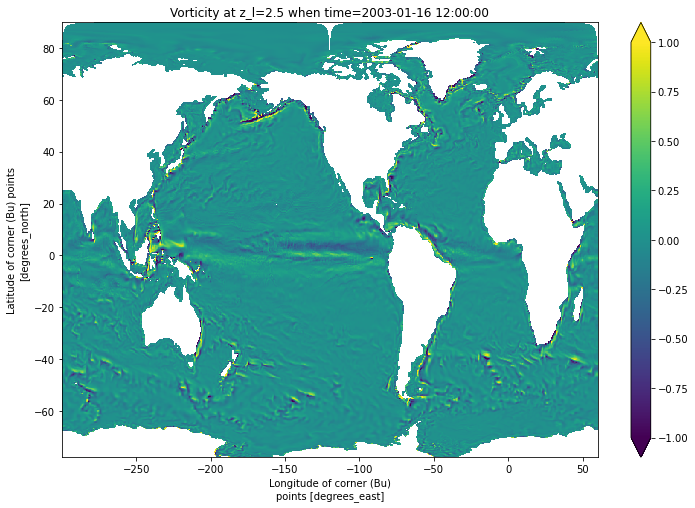

In [26]:
subplot_kws=dict(projection=ccrs.PlateCarree(),
                 facecolor='grey')

plt.figure(figsize=[12,8])
data_plot.plot(x='geolon_c', y='geolat_c', vmin=-1, vmax=1)
plt.title("Vorticity at z_l=2.5 when time=2003-01-16 12:00:00")
